<a href="https://colab.research.google.com/github/artem-dorofeev/py_DataScience_HW/blob/main/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [80]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [81]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [83]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [84]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [85]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
    # Вихідний шар з 10 нейронами (num_classes)
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)

    return self.out_layer(x, activation=1)

In [86]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

    # Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Отримати індекси класів з найвищою ймовірністю
    predicted_classes = tf.argmax(y_pred, axis=1)

    # Порівняти з істинними мітками
    correct_predictions = tf.equal(predicted_classes, tf.cast(y_true, dtype=tf.int64))

    # Обчислити середню точність
    return tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))


In [114]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Get the list of trainable variables
    trainable_variables = neural_net.trainable_variables

    # Compute gradients
    gradients = g.gradient(loss, trainable_variables)

    # Apply gradients to update parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))


In [98]:
# Навчання нейронної мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі


for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Викликаємо функцію тренування, яка містить усі необхідні кроки
    train(neural_net, batch_x, batch_y)

    # Кожні display_step ітерацій виводимо інформацію про поточний стан навчання
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print(f"Крок: {step}, Втрати: {loss}, Точність: {acc}")

        # Збережіть значення втрат та точності для графіків
        loss_history.append(loss)
        accuracy_history.append(acc)

# Після завершення навчання, виведемо інформацію про фінальні втрати та точність на тренувальній вибірці
final_pred = neural_net(x_train)
final_loss = cross_entropy(final_pred, y_train)
final_acc = accuracy(final_pred, y_train)
print(f"Фінальні втрати на тренувальній вибірці: {final_loss}")
print(f"Фінальна точність на тренувальній вибірці: {final_acc}")

Крок: 100, Втрати: 22.72953224182129, Точність: 0.98046875
Крок: 200, Втрати: 48.46227264404297, Точність: 0.9375
Крок: 300, Втрати: 43.679290771484375, Точність: 0.953125
Крок: 400, Втрати: 39.108856201171875, Точність: 0.953125
Крок: 500, Втрати: 35.839561462402344, Точність: 0.9609375
Крок: 600, Втрати: 37.73472595214844, Точність: 0.94921875
Крок: 700, Втрати: 22.48453712463379, Точність: 0.96484375
Крок: 800, Втрати: 20.561080932617188, Точність: 0.9765625
Крок: 900, Втрати: 39.31163024902344, Точність: 0.95703125
Крок: 1000, Втрати: 34.44740295410156, Точність: 0.95703125
Крок: 1100, Втрати: 41.75773620605469, Точність: 0.95703125
Крок: 1200, Втрати: 17.37617301940918, Точність: 0.984375
Крок: 1300, Втрати: 21.413097381591797, Точність: 0.98046875
Крок: 1400, Втрати: 27.000896453857422, Точність: 0.96875
Крок: 1500, Втрати: 37.06587219238281, Точність: 0.96484375
Крок: 1600, Втрати: 25.56998062133789, Точність: 0.97265625
Крок: 1700, Втрати: 46.38898468017578, Точність: 0.9570312

In [90]:
print(len(loss_history))
print(len(accuracy_history))

30
30


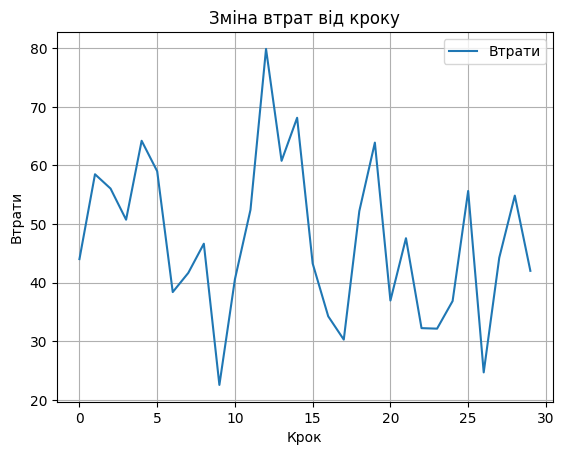

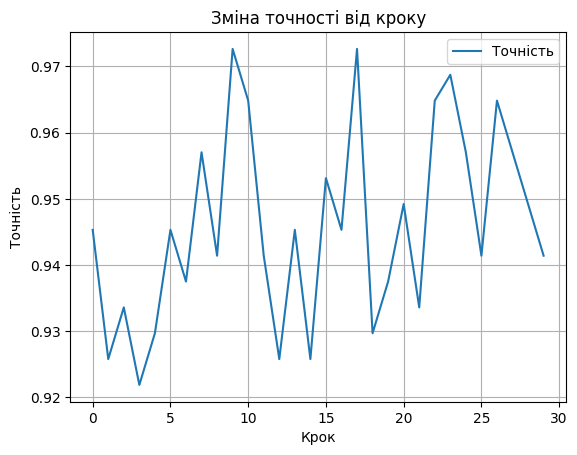

In [91]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, label='Втрати')
plt.title('Зміна втрат від кроку')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history, label='Точність')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()
plt.show()


In [92]:
# Обчисліть точність навченої нейромережі
final_pred_train = neural_net(x_train)
final_acc_train = accuracy(final_pred_train, y_train)
print(f"Фінальна точність на тренувальній вибірці: {final_acc_train}")

# Тестування моделі на тестових даних
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Точність на тестовій вибірці: {test_acc}")


Фінальна точність на тренувальній вибірці: 0.9505500197410583
Точність на тестовій вибірці: 0.9192000031471252


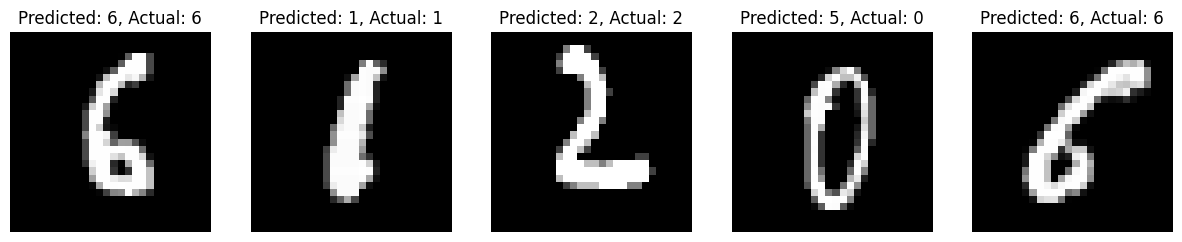

In [93]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Виберіть 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), 5)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

# Передайте обрані зображення в нейронну мережу
predictions = neural_net(images_to_test)

# Виведіть зображення та випишіть поруч відповідь нейромережі
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images_to_test[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Predicted: {tf.argmax(predictions[i], axis=0).numpy()}, Actual: {labels_to_test[i]}")
    plt.axis('off')
plt.show()






In [79]:
from sklearn.metrics import classification_report

# Передбачення для тренувальної вибірки
train_predictions = neural_net(x_train)

# Отримати індекси класів з передбачень
predicted_classes = tf.argmax(train_predictions, axis=1)

# Отримати classification report
report = classification_report(y_train, predicted_classes.numpy())

# Вивести звіт
print(report)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5923
           1       0.99      0.98      0.99      6742
           2       0.97      0.96      0.97      5958
           3       0.95      0.96      0.96      6131
           4       0.96      0.97      0.96      5842
           5       0.95      0.95      0.95      5421
           6       0.97      0.98      0.98      5918
           7       0.96      0.97      0.97      6265
           8       0.96      0.94      0.95      5851
           9       0.95      0.94      0.94      5949

    accuracy                           0.97     60000
   macro avg       0.96      0.96      0.96     60000
weighted avg       0.97      0.97      0.97     60000



 ***створимо дві додаткові моделі, одну зі зміненою кількістю прихованих шарів іншу зі зміненим методом оптимізації.***

In [94]:
class NNWithHiddenLayers(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)

        self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
        self.layer3 = DenseLayer(n_hidden_2, n_hidden_2, name="layer3")

        self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")

    def __call__(self, x):
        x = self.layer1(x, activation=0)
        x = self.layer2(x, activation=0)
        x = self.layer3(x, activation=0)

        return self.out_layer(x, activation=1)


In [107]:
neural_net_with_hidden_layers = NNWithHiddenLayers(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Get the list of trainable variables
    trainable_variables = neural_net.trainable_variables

    # Compute gradients
    gradients = g.gradient(loss, trainable_variables)

    # Apply gradients to update parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [108]:
# Навчання нейронної мережі

loss_history_2 = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history_2 = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі


for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Викликаємо функцію тренування, яка містить усі необхідні кроки
    train(neural_net_with_hidden_layers, batch_x, batch_y)

    # Кожні display_step ітерацій виводимо інформацію про поточний стан навчання
    if step % display_step == 0:
        pred = neural_net_with_hidden_layers(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print(f"Крок: {step}, Втрати: {loss}, Точність: {acc}")

        # Збережіть значення втрат та точності для графіків
        loss_history_2.append(loss)
        accuracy_history_2.append(acc)

# Після завершення навчання, виведемо інформацію про фінальні втрати та точність на тренувальній вибірці
final_pred_2 = neural_net_with_hidden_layers(x_train)
final_loss_2 = cross_entropy(final_pred_2, y_train)
final_acc_2 = accuracy(final_pred_2, y_train)
print(f"Фінальні втрати на тренувальній вибірці: {final_loss_2}")
print(f"Фінальна точність на тренувальній вибірці: {final_acc_2}")

Крок: 100, Втрати: 305.04425048828125, Точність: 0.6796875
Крок: 200, Втрати: 289.6638488769531, Точність: 0.671875
Крок: 300, Втрати: 163.76217651367188, Точність: 0.82421875
Крок: 400, Втрати: 154.74417114257812, Точність: 0.7890625
Крок: 500, Втрати: 143.07980346679688, Точність: 0.83984375
Крок: 600, Втрати: 129.41412353515625, Точність: 0.8359375
Крок: 700, Втрати: 90.87672424316406, Точність: 0.8984375
Крок: 800, Втрати: 100.66055297851562, Точність: 0.88671875
Крок: 900, Втрати: 85.1697998046875, Точність: 0.890625
Крок: 1000, Втрати: 105.24739837646484, Точність: 0.87890625
Крок: 1100, Втрати: 147.07281494140625, Точність: 0.8359375
Крок: 1200, Втрати: 111.93414306640625, Точність: 0.8828125
Крок: 1300, Втрати: 73.39642333984375, Точність: 0.90234375
Крок: 1400, Втрати: 99.320556640625, Точність: 0.8984375
Крок: 1500, Втрати: 73.29635620117188, Точність: 0.90234375
Крок: 1600, Втрати: 56.6185302734375, Точність: 0.93359375
Крок: 1700, Втрати: 71.20342254638672, Точність: 0.9140

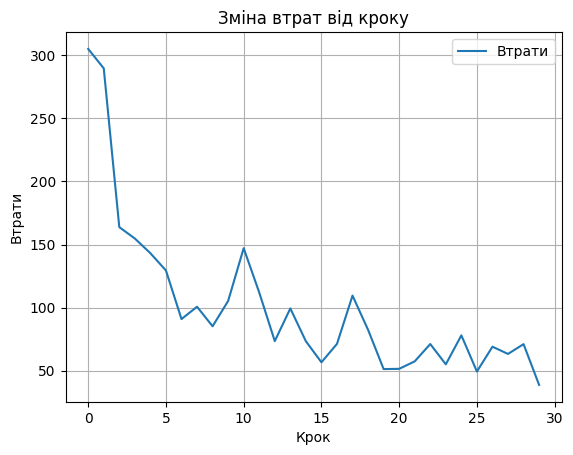

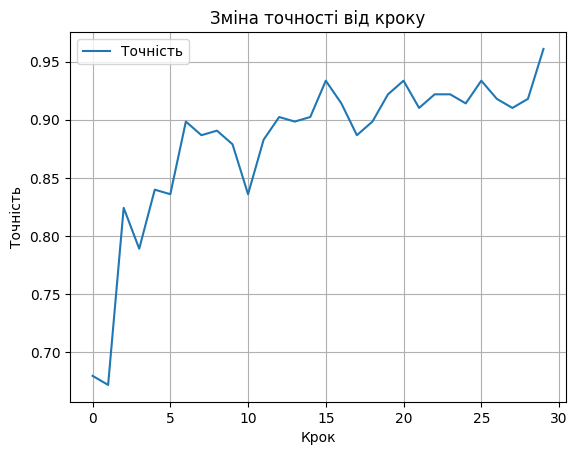

In [109]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат для НМ з змінено кількістю прихованих шарів
plt.plot(loss_history_2, label='Втрати')
plt.title('Зміна втрат від кроку')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()
plt.show()

# Виведіть графік точності для НМ з змінено кількістю прихованих шарів
plt.plot(accuracy_history_2, label='Точність')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()
plt.show()

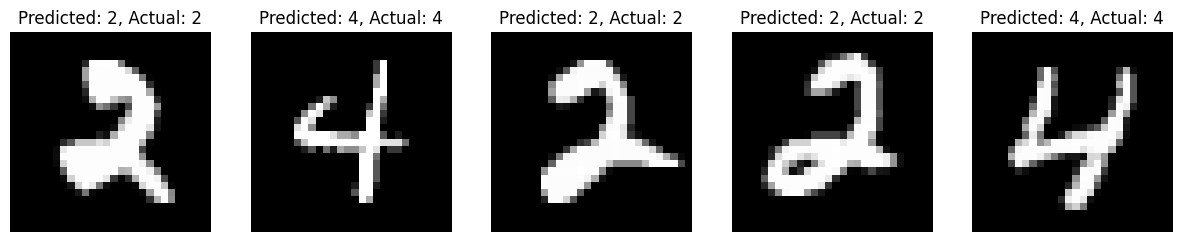

In [110]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Виберіть 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), 5)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

# Передайте обрані зображення в нейронну мережу
predictions = neural_net_with_hidden_layers(images_to_test)

# Виведіть зображення та випишіть поруч відповідь нейромережі
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images_to_test[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Predicted: {tf.argmax(predictions[i], axis=0).numpy()}, Actual: {labels_to_test[i]}")
    plt.axis('off')
plt.show()

In [116]:
class NNWithDifferentOptimizer(tf.Module):
    def __init__(self, name=None, optimizer_type="adam"):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
        self.out_layer = DenseLayer(n_hidden_2, num_classes, name="out_layer")

        self.optimizer_type = optimizer_type
        self.optimizer = self.get_optimizer()

    def get_optimizer(self):
        if self.optimizer_type == "adam":
            return tf.optimizers.Adam(learning_rate)
        elif self.optimizer_type == "rmsprop":
            return tf.optimizers.RMSprop(learning_rate)
        elif self.optimizer_type == "sgd":
            return tf.optimizers.SGD(learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer_type}")

    def __call__(self, x):
        x = self.layer1(x, activation=0)
        x = self.layer2(x, activation=0)

        return self.out_layer(x, activation=1)


In [112]:
# Створимо екземпляр нейронної мережі
neural_net_3 = NNWithDifferentOptimizer(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    # Get the list of trainable variables
    trainable_variables = neural_net.trainable_variables

    # Compute gradients
    gradients = g.gradient(loss, trainable_variables)

    # Apply gradients to update parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [113]:
# Навчання нейронної мережі

loss_history_3 = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history_3 = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі


for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Викликаємо функцію тренування, яка містить усі необхідні кроки
    train(neural_net_3, batch_x, batch_y)

    # Кожні display_step ітерацій виводимо інформацію про поточний стан навчання
    if step % display_step == 0:
        pred = neural_net_3(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print(f"Крок: {step}, Втрати: {loss}, Точність: {acc}")

        # Збережіть значення втрат та точності для графіків
        loss_history_3.append(loss)
        accuracy_history_3.append(acc)

# Після завершення навчання, виведемо інформацію про фінальні втрати та точність на тренувальній вибірці
final_pred_3 = neural_net_with_hidden_layers(x_train)
final_loss_3 = cross_entropy(final_pred_3, y_train)
final_acc_3 = accuracy(final_pred_3, y_train)
print(f"Фінальні втрати на тренувальній вибірці: {final_loss_3}")
print(f"Фінальна точність на тренувальній вибірці: {final_acc_3}")

Крок: 100, Втрати: 312.62213134765625, Точність: 0.67578125
Крок: 200, Втрати: 227.93856811523438, Точність: 0.74609375
Крок: 300, Втрати: 181.74526977539062, Точність: 0.7890625
Крок: 400, Втрати: 172.89627075195312, Точність: 0.796875
Крок: 500, Втрати: 145.582763671875, Точність: 0.8515625
Крок: 600, Втрати: 157.434326171875, Точність: 0.8359375
Крок: 700, Втрати: 102.43212127685547, Точність: 0.8671875
Крок: 800, Втрати: 126.27468872070312, Точність: 0.87890625
Крок: 900, Втрати: 100.93606567382812, Точність: 0.8671875
Крок: 1000, Втрати: 121.52864074707031, Точність: 0.859375
Крок: 1100, Втрати: 130.16372680664062, Точність: 0.82421875
Крок: 1200, Втрати: 74.89022827148438, Точність: 0.921875
Крок: 1300, Втрати: 84.39176940917969, Точність: 0.89453125
Крок: 1400, Втрати: 73.70965576171875, Точність: 0.91796875
Крок: 1500, Втрати: 71.88412475585938, Точність: 0.88671875
Крок: 1600, Втрати: 73.81866455078125, Точність: 0.9140625
Крок: 1700, Втрати: 100.26223754882812, Точність: 0.88

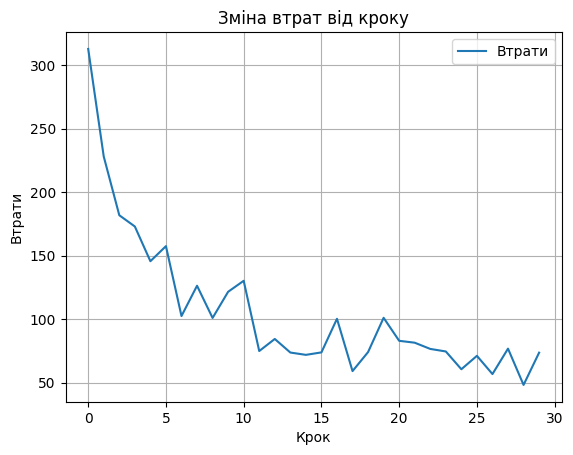

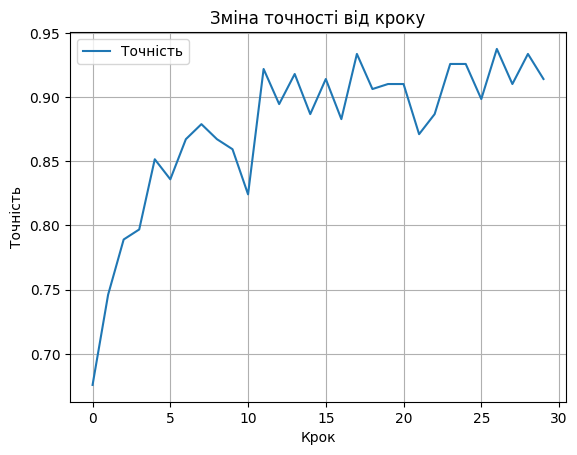

In [115]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат для НМ  зі зміненим методом оптимізації
plt.plot(loss_history_3, label='Втрати')
plt.title('Зміна втрат від кроку')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()
plt.show()

# Виведіть графік точності для НМ  зі зміненим методом оптимізації
plt.plot(accuracy_history_3, label='Точність')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()
plt.show()

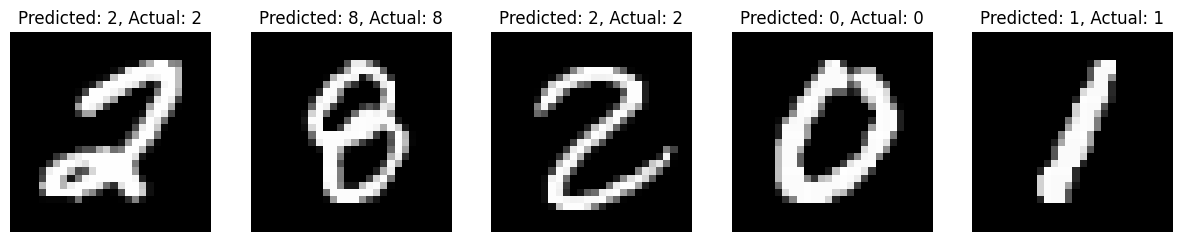

In [117]:
# Виберіть 5 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), 5)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

# Передайте обрані зображення в нейронну мережу
predictions = neural_net_3(images_to_test)

# Виведіть зображення та випишіть поруч відповідь нейромережі
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images_to_test[i].reshape((28, 28)), cmap='gray')
    plt.title(f"Predicted: {tf.argmax(predictions[i], axis=0).numpy()}, Actual: {labels_to_test[i]}")
    plt.axis('off')
plt.show()